In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import mne

import re
from tqdm import tqdm

DB_PATH = './db/v1.5.1/'

In [2]:
seiz_types_path = DB_PATH + '_DOCS/seizures_types_v02.xlsx'
seiz_types = pd.read_excel(seiz_types_path)

seiz_types = seiz_types.set_index('Class Code')
display(seiz_types)

,Class No.,Event Name,Signs,Locality,Description
Class Code,,,,,
NaN,0,No Event,NaN,NaN,An unclassified event
SPSW,1,Spike/Sharp and Wave,Electrographic,All,"Spike and wave/complexes , sharp and wave/comp..."
GPED,2,Generalized Periodic Epileptiform Discharges,Electrographic,Generalized,Diffused periodic discharges
PLED,3,Periodic Lateralized Epileptiform Discharges,Electrographic,Hemispheric/Focal,Focal periodic discharges
EYBL,4,Eye blink,Clinical & Electrographic,Focal,"A specific type of sharp, high amplitude eye m..."
ARTF,5,Artifacts (All),Clinical & Electrographic,All,"Any non-brain activity electrical signal, such..."
BCKG,6,Background,Electrographic,NaN,Baseline/non-interesting events
SEIZ,7,Seizure,Clinical &| Electrographic,All,Common seizure class which can include all typ...
FNSZ,8,Focal Non-Specific Seizure,Electrographic,Hemispheric/Focal,Focal seizures which cannot be specified with ...


In [3]:
seiz_info_path = DB_PATH +'_DOCS/seizures_v34r.xlsx'
train_info = pd.read_excel(seiz_info_path, 'train')

train_seiz_type = train_info.iloc[1:12,26:30]
train_seiz_type.columns = ['Class Code', 'Events', 'Freq.', 'Cum.']
train_seiz_type = train_seiz_type.set_index('Class Code')
train_seiz_type.join(seiz_types) 

,Events,Freq.,Cum.,Class No.,Event Name,Signs,Locality,Description
Class Code,,,,,,,,
FNSZ,1536,0.648101,0.648101,8.0,Focal Non-Specific Seizure,Electrographic,Hemispheric/Focal,Focal seizures which cannot be specified with ...
GNSZ,408,0.172152,0.820253,9.0,Generalized Non-Specific Seizure,Electrographic,Generalized,Generalized seizures which cannot be further c...
SPSZ,49,0.0206751,0.840928,10.0,Simple Partial Seizure,Clinical & Electrographic,All,Partial seizures during consciousness; Type sp...
CPSZ,277,0.116878,0.957806,11.0,Complex Partial Seizure,Clinical & Electrographic,All,Partial Seizures during unconsciousness; Type ...
ABSZ,50,0.021097,0.978903,12.0,Absence Seizure,Clinical & Electrographic,Generalized,Absence Discharges observed on EEG; patient lo...
TNSZ,18,0.00759494,0.986498,13.0,Tonic Seizure,Clinical & Electrographic,All,Stiffening of body during seizure (EEG effects...
CNSZ,0,0,0.986498,14.0,Clonic Seizure,Clinical & Electrographic,All,Jerking/shivering of body during seizure
TCSZ,30,0.0126582,0.999156,15.0,Tonic Clonic Seizure,Clinical & Electrographic,All,At first stiffening and then jerking of body (...
ATSZ,0,0,0.999156,16.0,Atonic Seizure,Clinical & Electrographic,NaN,Sudden loss of muscle tone


In [4]:
# ----------------
# Descriptive Keys
# ----------------
train_type_key = train_info.iloc[24:43,16:21]
train_type_key.columns = ['EEG Type', 'EEG SubType', 'Rooms', 'REMOVE', 'Description']
train_type_key = train_type_key.drop(['Rooms','REMOVE'], axis = 1)
train_type_key['EEG Type'] = train_type_key['EEG Type'].ffill()
train_type_key = train_type_key.set_index('EEG Type')

# ------------
# Type Summary
# ------------
train_type_summary = train_info.iloc[1:7,16:20]
train_type_summary.columns = ['EEG Type', 'Sessions', 'Freq.', 'Cum.']
train_type_summary = train_type_summary.set_index('EEG Type')

desc = train_type_key[train_type_key.isnull().any(axis=1)].iloc[:-1]
train_type_summary = train_type_summary.join(desc)
train_type_summary = train_type_summary.drop('EEG SubType', axis=1)

train_type_summary[['Description','Sessions', 'Freq.', 'Cum.']]

,Description,Sessions,Freq.,Cum.
EEG Type,,,,
EMU,NaN,162,0.136709,0.136709
ICU,Intensive Care Unit,438,0.36962,0.506329
Inpatient,Inpatient But Not ICU,350,0.295359,0.801688
Outpatient,Routine EEGs,193,0.162869,0.964557
Unknown,EEG Report Is Not Informative,42,0.035443,1
Total:,NaN,1185,1,NaN


In [5]:
# just want the info per file here
file_info = train_info.iloc[1:6101,1:15]
# cleans some of the names
file_info_cols = ['File No.', 'Patient', 'Session', 'File', 
                       'EEG Type', 'EEG SubType', 'LTM or Routine', 
                       'Normal/Abnormal', 'No. Seizures File', 
                       'No. Seizures/Session', 'Filename', 'Seizure Start', 
                       'Seizure Stop', 'Seizure Type']
file_info.columns = file_info_cols

# we forward fill as there are gaps in the excel file to represent the info 
# is the same as above (apart from in the filename, seizure start, seizure stop 
# and seizure type columns)
for col_name in file_info.columns[:-4]:
  file_info[col_name] = file_info[col_name].ffill()

# patient ID is an integer rather than float
file_info['Patient'] = file_info['Patient'].astype(int)

file_info.head()

,File No.,Patient,Session,File,EEG Type,EEG SubType,LTM or Routine,Normal/Abnormal,No. Seizures File,No. Seizures/Session,Filename,Seizure Start,Seizure Stop,Seizure Type
1,1.0,77,s003,t000,Outpatient,Outpatient,Routine,Abnormal,0.0,12.0,./train/01_tcp_ar/000/00000077/s003_2010_01_21...,NaN,NaN,NaN
2,2.0,254,s005,t000,Outpatient,Outpatient,Routine,Abnormal,0.0,0.0,./train/01_tcp_ar/002/00000254/s005_2010_11_15...,NaN,NaN,NaN
3,3.0,254,s006,t001,Outpatient,Outpatient,Routine,Abnormal,0.0,0.0,./train/01_tcp_ar/002/00000254/s006_2011_07_01...,NaN,NaN,NaN
4,4.0,254,s007,t000,Inpatient,General,Routine,Abnormal,0.0,0.0,./train/01_tcp_ar/002/00000254/s007_2013_03_25...,NaN,NaN,NaN
5,5.0,272,s007,t000,ICU,BURN,LTM,Abnormal,0.0,0.0,./train/01_tcp_ar/002/00000272/s007_2003_07_03...,NaN,NaN,NaN


In [6]:
# our example events file picked from the events filename
SEIZURE_EVENTS_FILE = file_info[file_info['No. Seizures File']>0]['Filename'].iloc[20]

# we use the above to get the file directory this file is in
example_file_dir = DB_PATH + 'edf/' + '/'.join(SEIZURE_EVENTS_FILE.split('/')[1:-1])

print(example_file_dir)
print(SEIZURE_EVENTS_FILE)

./db/v1.5.1/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01
./train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.tse


In [7]:
'''
Load data from one file
'''
def data_load(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              # This happens if the sampling rate of that channel is 
              # different to the others.
              # For simplicity, in this case we just make it na.
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        # round these to the lowest nearest decimal to get the seconds
        #seconds = np.floor(index_increase).astype('uint16')

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None

seiz_edf_name = SEIZURE_EVENTS_FILE.split('/')[-1][:-3]+'edf'
seiz_edf_file = example_file_dir +'/'+ seiz_edf_name
seiz_data, seiz_freq = data_load(seiz_edf_file)

print(seiz_edf_file)
display(seiz_data.shape)

./db/v1.5.1/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.edf


(400250, 36)

In [8]:
def mne_object(data, freq, events_tse = pd.DataFrame()):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if not events_tse.empty:

    raw.set_annotations(mne.Annotations(events_tse['Start'],
                                          events_tse['End'] - events_tse['Start'],
                                          events_tse['Code']))

  return raw

seiz_events_name = SEIZURE_EVENTS_FILE.split('/')[-1]
events_tse = pd.read_csv(example_file_dir+'/'+seiz_events_name, 
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])

tuh_mne = mne_object(seiz_data, seiz_freq, events_tse)

print(example_file_dir+'/'+seiz_events_name)

Creating RawArray with float64 data, n_channels=36, n_times=400250
    Range : 0 ... 400249 =      0.000 ...  1600.996 secs
Ready.
./db/v1.5.1/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.tse


Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



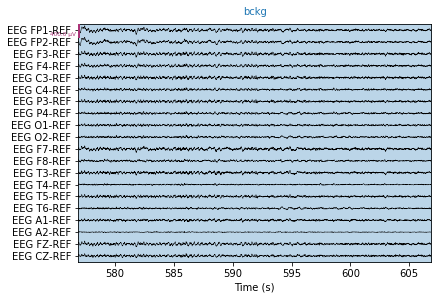

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



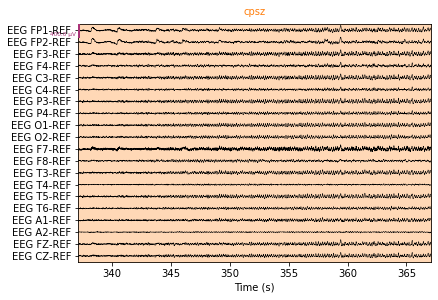

In [9]:
plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}


for class_code in events_tse['Code'].unique():
    code_events = events_tse.where(events_tse['Code'] == class_code).dropna()
    tuh_mne.plot(start = code_events.sample(random_state = 0)['Start'].values[0], 
                    duration = 30, **plot_kwargs)

In [10]:
# What type of seizure in TUH (If `None` will do all)?
TUH_code = 'GNSZ'

def sel_file_list(set_name, seiz_type):
    # load the training information
    seiz_info_path = DB_PATH +'_DOCS/seizures_v34r.xlsx'
    train_info = pd.read_excel(seiz_info_path, 'train')
    # just want the info per file here
    file_info = train_info.iloc[1:6101,1:15]
    # cleans some of the names
    file_info_cols = ['File No.', 'Patient', 'Session', 'File', 
                          'EEG Type', 'EEG SubType', 'LTM or Routine', 
                          'Normal/Abnormal', 'No. Seizures File', 
                          'No. Seizures/Session', 'Filename', 'Seizure Start', 
                          'Seizure Stop', 'Seizure Type']
    file_info.columns = file_info_cols

    # we forward fill as there are gaps in the excel file to represent the info 
    # is the same as above (apart from in the filename, seizure start, seizure stop 
    # and seizure type columns)
    for col_name in file_info.columns[:-4]:
        file_info[col_name] = file_info[col_name].ffill()

    # patient ID is an integer rather than float
    file_info['Patient'] = file_info['Patient'].astype(int)

    if seiz_type:
        # Get a list of patient event files that have a specifc type of seizure
        return list(file_info[file_info['Seizure Type']==seiz_type]['Filename'])
    else:
        return list(file_info['Filename'])

int_code = seiz_types.to_dict()['Class No.']
# change to lower case
int_code = { k.lower() : v for k,v in int_code.items() if not isinstance(k, float)}

# get a list of files
tuh_file_list = sel_file_list('train', TUH_code)+sel_file_list('dev_test', TUH_code)


In [23]:
print(len(tuh_file_list))

print(tuh_file_list[0])

print(int_code)


#print(tuh_file_list)

186
./train/03_tcp_ar_a/115/00011580/s002_2014_05_04/00011580_s002_t008.tse
{'spsw': 1, 'gped': 2, 'pled': 3, 'eybl': 4, 'artf': 5, 'bckg': 6, 'seiz': 7, 'fnsz': 8, 'gnsz': 9, 'spsz': 10, 'cpsz': 11, 'absz': 12, 'tnsz': 13, 'cnsz': 14, 'tcsz': 15, 'atsz': 16, 'mysz': 17, 'nesz': 18, 'intr': 19, 'slow': 20, 'eyem': 21, 'chew': 22, 'shiv': 23, 'musc': 24, 'elpp': 25, 'elst': 26, 'calb': 27, 'hphs': 28, 'trip': 29}


In [12]:
# get a list of the montages
montage = []
for file in tuh_file_list:
    montage.append(file.split('/')[3])
    
# count how many times the montages appear in the data
montage_counts = pd.Series(montage).value_counts()

#print(montage_counts)

# remove all files apart from those in the most common montage
#regex = re.compile(montage_counts.index[0])
#tuh_file_list = [i for i in tuh_file_list if regex.search(i)]
# remove duplicates
tuh_file_list = list(set(tuh_file_list))

print(len(tuh_file_list))


186


In [13]:
# --------------------
# GET SIMILAR CHANNELS
# --------------------
# this is to make sure all the data have the same channels
all_channels = []
for events_path in tqdm(tuh_file_list, desc = 'Finding Channels'):
    file_ID = events_path.split('/')[-1][:-4]
    # we use the above to get the file directory this file is in
    pat_file_dir = 'edf/' + '/'.join(events_path.split('/')[1:-1])
    
    file_path = DB_PATH+pat_file_dir+'/'+file_ID+'.edf'
    #print(file_path)
    
    with pyedflib.EdfReader(file_path) as f:
        # get the names of the signals
        all_channels.extend(f.getSignalLabels())

# turn the list into a pandas series
all_channels = pd.Series(all_channels)

# count how many times the channels appear in each participant
channel_counts = all_channels.value_counts()
  
# threshold the channels to only those found in all raw data
channel_keeps = list(channel_counts[channel_counts >= channel_counts[0]].index)
regex = re.compile('30|PHOTIC|EKG|PG')
channel_keeps = [i for i in channel_keeps if not regex.search(i)]

print(channel_keeps)

Finding Channels: 100%|████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 3320.72it/s]

['EEG T5-REF', 'EEG FP1-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG O2-REF', 'EEG T6-REF', 'EEG CZ-REF', 'EEG FZ-REF', 'EEG P4-REF', 'EEG C3-REF', 'EEG P3-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG C4-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG PZ-REF', 'EEG F7-REF', 'EEG O1-REF']


In [14]:
ATT_START = 0
ATT_END = 0

import chardet
def create_events(file_name, df, code = None):

    data_y = pd.Series(index=df.index)
    data_y.name = 'Events'
    
    events_tse = pd.read_csv(file_name,
                             skiprows=1,
                             sep = ' ',
                             header=None,
                             names =['Start', 'End', 'Code', 'Certainty'])
    
    data_y = data_y.fillna('bckg')
    
    
    for pos, row in events_tse.iterrows():
        # if you want to manually set the code
        if code != None:
          if row['Code'] == code:
              data_y[row['Start']:row['End']] = code
        # let it be the code it is in the event file
        else:
          data_y[row['Start']:row['End']] = row['Code']

    return data_y

In [15]:
# Read files into df and create events series
for events_path in tqdm(tuh_file_list, desc='Reading files'):
    file_ID = events_path.split('/')[-1][:-4]
    # we use the above to get the file directory this file is in
    pat_file_dir = 'edf/' + '/'.join(events_path.split('/')[1:-1])
    
    file_path = DB_PATH+pat_file_dir+'/'+file_ID+'.edf'
    #print(file_path)
    pat_ID = events_path.split('/')[-3]

    # load data
    raw_data, freq = data_load(file_path, channel_keeps)
    
    if raw_data.empty:
        print('Skipped: '+file_ID)
    else:
        raw_events = create_events(DB_PATH+pat_file_dir+'/'+file_ID+'.tse', raw_data)
        # change to integer representation
        #raw_events = raw_events.replace(int_code)


Reading files:   0%|                                                                           | 0/186 [00:00<?, ?it/s]<ipython-input-14-000e68478807>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data_y = pd.Series(index=df.index)
Reading files: 100%|█████████████████████████████████████████████████████████████████| 186/186 [01:22<00:00,  2.26it/s]


In [16]:
# Replace labels in pd series, 0 for no seizure and 1 for seizure
raw_events = raw_events.replace('bckg',0)
raw_events = raw_events.replace(TUH_code.lower(),1)

print(raw_events)
display(raw_data)

Time
0.000      0
0.004      0
0.008      0
0.012      0
0.016      0
          ..
627.980    0
627.984    0
627.988    0
627.992    0
627.996    0
Name: Events, Length: 157000, dtype: int64


Channel,EEG T5-REF,EEG FP1-REF,EEG F4-REF,EEG F8-REF,EEG O2-REF,EEG T6-REF,EEG CZ-REF,EEG FZ-REF,EEG P4-REF,EEG C3-REF,EEG P3-REF,EEG T3-REF,EEG T4-REF,EEG C4-REF,EEG FP2-REF,EEG F3-REF,EEG PZ-REF,EEG F7-REF,EEG O1-REF
Time,,,,,,,,,,,,,,,,,,,
0.000,-19.069470,2.179045,0.171311,2.346356,-4.513401,-10.703913,-13.046269,-13.548202,-13.548202,-11.038535,-23.586870,-14.050135,-10.703913,-6.521134,1.007867,-15.890558,24.431426,-10.201979,-39.481428
0.004,-24.590737,3.182912,1.175178,4.688712,-1.669111,-9.030801,-12.377024,-13.548202,-13.213580,-13.213580,-42.827651,-14.552069,-12.042402,-5.349956,2.011734,-18.734847,31.793116,-9.867357,-44.500762
0.008,-17.563669,-3.676845,-6.186512,1.007867,-2.505667,-13.213580,-10.536602,-11.038535,-16.057869,-6.019201,-9.365424,-16.392491,-9.365424,-10.536602,-4.346090,-13.046269,24.598737,-15.221313,-37.641006
0.012,-11.707780,-4.680712,-6.855757,2.011734,-3.342223,-13.882824,-13.882824,-13.715513,-17.061736,-4.346090,15.062002,-17.563669,-5.349956,-12.042402,-5.349956,-12.209713,22.423692,-16.894425,-36.971761
0.016,-14.552069,2.179045,0.505933,8.202246,1.007867,-4.178778,-14.384758,-15.388625,-10.034668,-10.201979,-16.225180,-10.871224,-3.007600,-3.844156,0.840556,-15.221313,26.439160,-7.357690,-35.800583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627.980,-24.423426,-12.711646,-13.380891,-16.057869,-13.548202,-20.909892,-14.552069,-13.715513,-23.586870,-10.201979,-27.936960,-21.077203,-21.913759,-16.727114,-7.859623,-18.232914,-12.878957,-19.906025,-22.248381
627.984,-14.886691,-17.061736,-18.065603,-18.902158,-13.213580,-25.259982,-15.890558,-14.384758,-27.435026,-4.178778,19.412092,-24.256115,-19.738714,-21.746448,-12.544335,-15.890558,-18.567536,-25.594604,-15.221313
627.988,-15.890558,-10.703913,-11.205846,-13.213580,-10.201979,-18.065603,-17.229047,-16.894425,-21.244514,-10.536602,2.346356,-20.909892,-17.229047,-14.886691,-7.190379,-19.236781,-13.882824,-20.240647,-13.380891
